In [1]:
!pip install import_ipynb
import import_ipynb
from google.colab import drive
drive.mount('/content/gdrive',  force_remount=True)
%cd /content/gdrive/My Drive/Project FPAR2/ego-rnn

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=b3afa15854127a3d1cc0d6efed0e5c0b3047cb174009b9cafd3b6927c6a9f773
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


KeyboardInterrupt: ignored

In [4]:
import torch
import resnetMod
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from MyConvLSTMCell import *
!pip install tensorboardX
from tensorboardX import SummaryWriter
from makeDatasetSparnet import *
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import glob
import random
from google.colab import drive
from PIL import Image
from torch.nn import functional as F
from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip)
from torchvision.transforms import *
!pip install tensorboardX
from tensorboardX import SummaryWriter
import argparse
import sys

class MSHead(nn.Module): 

    def __init__(self, regression, kernel=3, padding=1, stride=1):
        super(MSHead, self).__init__()
        self.relu=nn.ReLU(inplace=False)
        self.convol2=torch.nn.Conv2d(in_channels=512, out_channels=100, kernel_size=kernel, stride=stride, padding=padding)
        self.regression=regression
        # bzx100x7x7
        if self.regression==False:
            self.supm=nn.Linear(100*7*7,2*7*7) #bzx2*7*7
        else:
            self.supm=nn.Linear(100*7*7,7*7)
            self.sigm=nn.Sigmoid()
        torch.nn.init.xavier_uniform(self.supm.weight)
        torch.nn.init.xavier_uniform(self.convol2.weight)

    def forward(self, x):
        regression=self.regression
        x = self.relu(x)
        x = self.convol2(x)
        x = x.view(x.size(0), -1)
        x = self.supm(x)
        if regression==False:
            x = x.view(x.size(0),2,7,7)
        else:
            x = x.view(x.size(0),7,7)
            x=self.sigm(x)
        return x

class CNNTrunk(nn.Module):
    def __init__(self, num_classes=61, mem_size=512):
        super(CNNTrunk, self).__init__()
        self.num_classes = num_classes
        self.resNet = resnetMod.resnet34(True, True)
        self.mem_size = mem_size
        self.weight_softmax = self.resNet.fc.weight
        self.lstm_cell = MyConvLSTMCell(512, mem_size)
        self.avgpool = nn.AvgPool2d(7)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(mem_size, self.num_classes)
        self.classifier = nn.Sequential(self.dropout, self.fc)

    def forward(self, inputVariable, ms_head, loss, label_mmap):
        state = (Variable(torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).cuda()),
                 Variable(torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).cuda()))
        loss_ms_local=0
        for t in range(inputVariable.size(0)):
            logit, feature_conv, feature_convNBN = self.resNet(inputVariable[t])
            bz, nc, h, w = feature_conv.size() 
            feature_conv1 = feature_conv.view(bz, nc, h*w)
            probs, idxs = logit.sort(1, True) #Qua sta sortando gli indici per numero maggiore: vuole vedere quale è l'output più sicuro
            class_idx = idxs[:, 0]
            cam = torch.bmm(self.weight_softmax[class_idx].unsqueeze(1), feature_conv1) 
            #sta moltiplicando l'array delle classi più probabili per l'activation cam
            attentionMAP = F.softmax(cam.squeeze(1), dim=1)
            attentionMAP = attentionMAP.view(attentionMAP.size(0), 1, 7, 7)
            attentionFeat = feature_convNBN * attentionMAP.expand_as(feature_conv)
            out_mmap=ms_head(feature_conv.cuda()) 
            loss_ms_local+=loss(out_mmap.cuda(), label_mmap[t])
            state = self.lstm_cell(attentionFeat, state)
        feats1 = self.avgpool(state[1]).view(state[1].size(0), -1)
        feats = self.classifier(feats1)
        return feats, feats1, loss_ms_local/inputVariable.size(0)

In [5]:

!pip install import_ipynb
import import_ipynb

train_data_dir='/content/gdrive/My Drive/Project FPAR2/ego-rnn/GTEA61/processed_frames2'
val_data_dir='/content/gdrive/My Drive/Project FPAR2/ego-rnn/GTEA61/processed_frames2'
path_rgb='/content/gdrive/My Drive/Project FPAR2/ego-rnn/experiments/rgb/stage2/cam/16f/model_rgb_state_dict.pth'
path_save='/content/gdrive/My Drive/Project FPAR2/ego-rnn/experiments/sparnet/cam/16/3/model_rgb_state_dict.pth'
out_dir='experiments/sparnet'
seqLen=16
trainBatchSize=32
valBatchSize=64
numEpochs=150
lr1=1e-4
decay_factor=0.1
decay_step=[25,75,150]
memSize=512
regression=True

from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip)

def init(dir, path_rgb, regression, kernel, padding, stride):
  from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip)
  normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  spatial_transform_rgb_train=Compose([Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224),
                                  ToTensor(), normalize])
  spatial_transform_rgb_val=Compose([Scale(256),  CenterCrop(224), ToTensor(), normalize])
  from torchvision.transforms import Resize, CenterCrop as Center, ToTensor as Tensor, Compose as Compose2
  spatial_transform_mmap=Compose2([Resize(256), Center(224), Resize(size=(7,7)), Tensor()])
  vid_seq_train = makeDataset(dir, spatial_transform_rgb=spatial_transform_rgb_train, spatial_transform_mmap=spatial_transform_mmap, seqLen=seqLen, fmt='.png', train=True, regression=regression)
  train_loader = torch.utils.data.DataLoader(vid_seq_train, batch_size=trainBatchSize,
                              shuffle=True, num_workers=3, pin_memory=True)
  vid_seq_val = makeDataset(dir, spatial_transform_rgb=spatial_transform_rgb_val, spatial_transform_mmap=spatial_transform_mmap, seqLen=seqLen, fmt='.png', train=False, regression=regression)
  val_loader = torch.utils.data.DataLoader(vid_seq_val, batch_size=trainBatchSize,
                              shuffle=False, num_workers=3, pin_memory=True)
  
  num_classes=61
  model = CNNTrunk(num_classes=num_classes, mem_size=memSize).cuda()
  model.load_state_dict(torch.load(path_rgb))
  ms=MSHead(regression=regression, kernel=kernel, padding=padding, stride=stride).cuda() 
  
  return train_loader, val_loader, model, ms





In [6]:
import shutil
import os
def train_net(train_loader, val_loader, model, ms, path_save, loss_ms, seqLen, trainBatchSize, valBatchSize, numEpochs, lr1, decay_factor, decay_step, memSize, regression, alpha):
#Add a flag: if regression, labelmap should be float, if classification long.
    train_params = []

    for params in ms.supm.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in ms.convol2.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.parameters():
        params.requires_grad = False

    for params in model.resNet.layer4[0].conv1.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.resNet.layer4[0].conv2.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.resNet.layer4[1].conv1.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.resNet.layer4[1].conv2.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.resNet.layer4[2].conv1.parameters():
        params.requires_grad = True
        train_params += [params]
            #
    for params in model.resNet.layer4[2].conv2.parameters():
        params.requires_grad = True
        train_params += [params]
            #
    for params in model.resNet.fc.parameters():
        params.requires_grad = True
        train_params += [params]

    ms.convol2.train(True)
    ms.supm.train(True)

    model.resNet.layer4[0].conv1.train(True)
    model.resNet.layer4[0].conv2.train(True)
    model.resNet.layer4[1].conv1.train(True)
    model.resNet.layer4[1].conv2.train(True)
    model.resNet.layer4[2].conv1.train(True)
    model.resNet.layer4[2].conv2.train(True)

    for params in model.lstm_cell.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.classifier.parameters():
        params.requires_grad = True
        train_params += [params]

    model.lstm_cell.train(True)

    model.classifier.train(True)
    model.resNet.fc.train(True)
    model.classifier.train(True)
    model.cuda()

    loss_fn = nn.CrossEntropyLoss()

    optimizer_fn = torch.optim.Adam(train_params, lr=lr1, weight_decay=4e-5, eps=1e-4)
    optim_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=decay_step, gamma=decay_factor)
    
    model_folder=path_save

    writer = SummaryWriter(model_folder)
    train_log_loss = open((model_folder + '/train_log_loss.txt'), 'w')
    train_log_acc = open((model_folder + '/train_log_acc.txt'), 'w')
    val_log_loss = open((model_folder + '/val_log_loss.txt'), 'w')
    val_log_acc = open((model_folder + '/val_log_acc.txt'), 'w')
      
    train_loss_list=[]
    val_loss_list=[]
    train_acc_list=[]
    val_acc_list=[]
    ms_train_loss_list=[]
    ms_val_loss_list=[]

    min_accuracy = 0
    best_epoch=0

    for epoch in range(numEpochs):

        optim_scheduler.step()
        epoch_loss = 0
        numCorrTrain = 0
        trainSamples = 0
        iter=0

        numCorrTrain_ms=0
        trainSamples_ms=0

        model.lstm_cell.train(True)
        model.classifier.train(True)
        model.resNet.layer4[0].conv1.train(True)
        model.resNet.layer4[0].conv2.train(True)
        model.resNet.layer4[1].conv1.train(True)
        model.resNet.layer4[1].conv2.train(True)
        model.resNet.layer4[2].conv1.train(True)
        model.resNet.layer4[2].conv2.train(True)
        model.resNet.fc.train(True)
        ms.train(True)

        print(f'Epoch {epoch}')
        
        loss_ms_epoch=0
        loss_classifier_epoch=0 

        for rgb, mmap, label in train_loader:

            iter+=1
            trainSamples+=rgb.size(0)
            rgb=Variable(rgb.permute(1,0,2,3,4).to(device='cuda'))
            
            label=Variable(label).to(device='cuda')

            #mmap=(mmap>0.1).long()
            if regression==False:
                mmap=Variable(mmap.squeeze().long().permute(1,0,2,3).to(device='cuda'))
            else:
                mmap=Variable(mmap.squeeze().float().permute(1,0,2,3).to(device='cuda'))

            optimizer_fn.zero_grad()
            output_label, f, loss_m = model(rgb, ms, loss_ms, mmap) 

            #Now trasforming idts_labels into arrays of 7,32,49
            #idts_labels=(idts_labels>0.05).float().view(idts_labels.size(0),idts_labels.size(1),-1)

            loss_classifier=loss_fn(output_label, label)
            loss_ms_epoch+=loss_m.item()
            loss_classifier_epoch+=loss_classifier.item()


            loss=loss_m*alpha+loss_classifier
            loss.backward()

            #Computing accuracy

            _, predicted = torch.max(output_label.data, 1)
            numCorrTrain += (predicted == label).sum().item()
            optimizer_fn.step()
            
        avg_ms_loss=loss_ms_epoch/iter
        avg_loss=loss_classifier_epoch/iter
        accuracy=numCorrTrain/trainSamples*100

        print('Ms task loss')
        print(avg_ms_loss)
        print('Local classifier loss')
        print(avg_loss)
        print('Accuracy classifier')
        print(accuracy)

        train_acc_list.append(accuracy)
        train_loss_list.append(avg_loss)
        ms_train_loss_list.append(avg_ms_loss)

        writer.add_scalar('train/epoch_loss', avg_loss, epoch+1)
        writer.add_scalar('train/accuracy', accuracy, epoch+1)

        train_log_loss.write('Train Loss after {} epochs = {}\n'.format(epoch + 1, avg_loss))
        train_log_acc.write('Train Accuracy after {} epochs = {}%\n'.format(epoch + 1, accuracy))

        model.train(False)
        ms.train(False)

        loss_ms_epoch=0
        loss_classifier_epoch=0 
        epoch_loss = 0
        numCorrTrain = 0
        trainSamples = 0
        iter=0

        for rgb, mmap, label in val_loader:

            iter+=1
            trainSamples+=rgb.size(0)
            rgb=Variable(rgb.permute(1,0,2,3,4).to(device='cuda'))
            label=Variable(label).to(device='cuda')
            if regression==False:
                mmap=Variable(mmap.squeeze().long().permute(1,0,2,3).to(device='cuda'))
            else:
                mmap=Variable(mmap.squeeze().float().permute(1,0,2,3).to(device='cuda'))
            optimizer_fn.zero_grad()
            output_label, f, loss_m = model(rgb, ms, loss_ms, mmap) 
            loss_classifier=loss_fn(output_label, label)
            loss_ms_epoch+=loss_m.item()
            loss_classifier_epoch+=loss_classifier.item()
            _, predicted = torch.max(output_label.data, 1)
            numCorrTrain += (predicted == label).sum().item()
            optimizer_fn.step()
          
        avg_ms_loss=loss_ms_epoch/iter
        avg_loss=loss_classifier_epoch/iter
        accuracy=numCorrTrain/trainSamples*100

        print('Ms task loss val')
        print(avg_ms_loss)
        print('Local classifier loss val')
        print(avg_loss)
        print('Accuracy classifier val')
        print(accuracy)

        if accuracy>min_accuracy:
          min_accuracy=accuracy
          best_epoch=epoch
          if os.path.isdir(path_save):
            print('found')
            shutil.rmtree(path_save)
            print('cancel')
          else:
            print('not a folder')
          torch.save(model.state_dict(), path_save)

        val_loss_list.append(avg_loss)
        val_acc_list.append(accuracy)

        writer.add_scalar('train/epoch_loss', avg_loss, epoch+1)
        writer.add_scalar('train/accuracy', accuracy, epoch+1)

        train_log_loss.write('Train Loss after {} epochs = {}\n'.format(epoch + 1, avg_loss))
        train_log_acc.write('Train Accuracy after {} epochs = {}%\n'.format(epoch + 1, accuracy))

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_epoch


In [15]:
#HYPERPARAMETERS
val_data_dir='/content/gdrive/My Drive/Project FPAR2/ego-rnn/GTEA61/processed_frames2'
path_rgb='/content/gdrive/My Drive/Project FPAR2/ego-rnn/experiments/rgb/stage2/cam/16f/model_rgb_state_dict.pth'
path_save='./experiments/sparnet/cam/16/14/model_sparnet_state_dict.pth'
out_dir='experiments/sparnet'
seqLen=16
trainBatchSize=32
valBatchSize=64
numEpochs=80
lr1=1e-4
decay_factor=0.1
decay_step=[25,75,150]
memSize=512
alpha=0.001

train_loader, val_loader, model, ms=init(train_data_dir, path_rgb, True, 5, 2, 1)
from torch.nn import BCELoss
from torch.nn import CosineEmbeddingLoss
loss_ms=torch.nn.MSELoss()
train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_epoch=train_net(train_loader, val_loader, model, ms, path_save, loss_ms, seqLen, trainBatchSize, valBatchSize, numEpochs, lr1, decay_factor, decay_step, memSize, True, alpha)


MyConvLSTMCell.ipynb:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTMCell.ipynb:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
MyConvLSTMCell.ipynb:33: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTMCell.ipynb:35: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTMCell.ipynb:36: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
MyConvLSTMCell.ipynb:37: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTMCell.ipynb:39: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTMCell.ipynb:40: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
MyConvLSTMCell.ipynb:41: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyCo

Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ms task loss
0.29697575081478467
Local classifier loss
1.887126239863309
Accuracy classifier
45.16129032258064
Ms task loss val
0.2791820392012596
Local classifier loss val
1.974050760269165
Accuracy classifier val
50.0
found
cancel
Epoch 1
Ms task loss
0.23976018618453632
Local classifier loss
1.638264536857605
Accuracy classifier
52.19941348973607
Ms task loss val
0.23440947011113167
Local classifier loss val
2.3668379485607147
Accuracy classifier val
38.793103448275865
Epoch 2
Ms task loss
0.2058375667441975
Local classifier loss
1.8044935573231091
Accuracy classifier
50.733137829912025
Ms task loss val
0.2000010423362255
Local classifier loss val
1.998016357421875
Accuracy classifier val
48.275862068965516
Epoch 3
Ms task loss
0.17478115585717288
Local classifier loss
1.674787543036721
Accuracy classifier
51.61290322580645
Ms task loss val
0.16740971058607101
Local classifier loss val
1.8730465173721313
Accuracy classifier val
44.827586206896555
Epoch 4
Ms task loss
0.1528919853947

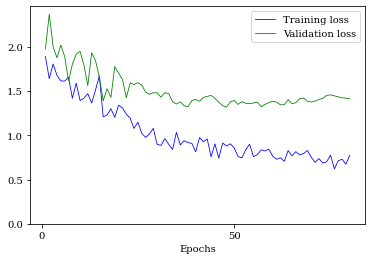

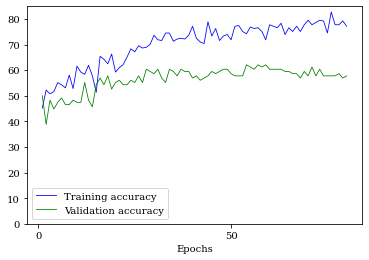

53


In [16]:
from plotting import *
plotting(train_loss_list, val_loss_list, train_acc_list,val_acc_list)
print(best_epoch)

In [ ]:
loss_ms=torch.nn.CosineEmbeddingLoss()
o=torch.ones(3,7,7)
z=torch.zeros(3,7,7)
y=torch.ones(3,7)
torch.ones(o.size()[0])
loss_ms(o,z,y)

tensor(1.)